## 1、加载波士顿房价数据集

In [46]:
from keras.datasets import boston_housing 

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

查看训练集和验证集上的数据

In [47]:
print(f"train_data's shape: {train_data.shape}")
print(f"test_data's shape: {test_data.shape}")

train_data's shape: (404, 13)
test_data's shape: (102, 13)


In [48]:
print(train_data[0])
print(train_targets[0])

[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]
15.2


## 2、数据的预处理
将取值范围差异很大的数据输入到神经网络当中，网络可能会自动适应这种取值范围不同的数据，但学习肯定会变得更加困难  
对于这种数据，普遍采取的最佳实践是对每个特征做标准化处理  
数据的标准化: (数据值x - 平均值μ) / (方差σ)  
  
#### 在这里从训练集上得到需要的平均值mean和方差std   
#### 再用得到的方差在训练集和验证集上进行预处理

In [49]:
mean = train_data.mean(axis = 0)
std = train_data.std(axis = 0)

train_data -= mean
train_data /= std

test_data -= mean
test_data /= std

查看得到的均值mean和方差std

In [ ]:
print(f"mean: {mean}")
print(f"std : {std}")

## 3、构建网络
在这里构建一个非常小的网络，只有两个隐藏层，每层有64个神经元  
#### notes:这是回归问题，和之前的分类问题有所不同，前者最后一层不需要激活函数

在这里定义一个build_model函数,避免在后面冗余的代码

### notes:  
回归问题常用的损失函数是均方误差(MSE, mean square error)  
常用的度量指标是平均绝对误差(MAE, mean absolute error)

In [50]:
from keras import models, layers

def build_model():
    network = models.Sequential()
    network.add(layers.Dense(64, activation = 'relu', input_shape = (13, )))
    network.add(layers.Dense(64, activation = 'relu'))
    network.add(layers.Dense(1))
    
    network.compile(optimizer = 'rmsprop',
                    loss = 'mse',
                    metrics = 'mae')
    return network

绘制网络模型

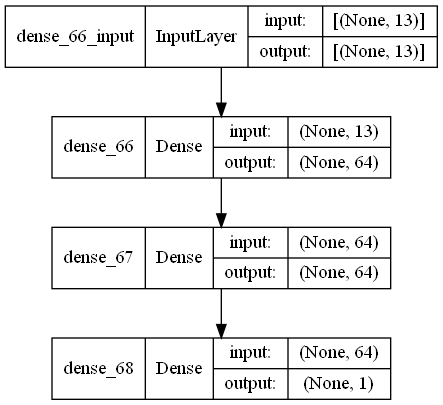

In [51]:
from tensorflow.keras.utils import plot_model

network = build_model()
plot_model(network, show_shapes = True, to_file = '房价回归.png')

## 4、利用K折交叉验证来训练模型（重点）
#### 由于数据集非常小，我们采用K折交叉验证的方式来训练模型  
K折交叉验证的方法：  
train_data[0.....len(train_data)/k.....(i-1) * len(train_data)/k....i * len(train_data)/k.....len(train_data)-1]  
第i次交叉验证，选择train_data[(i-1) * len(train_data)/k....i * len(train_data)/k)之间的数据作为验证集，
剩下的数据作为训练集

#### 实例化K个相同的模型，将每个模型在K-1个分区上进行训练，并在剩下的一个分区上进行验证  
模型验证分数等于K个验证分数的平均值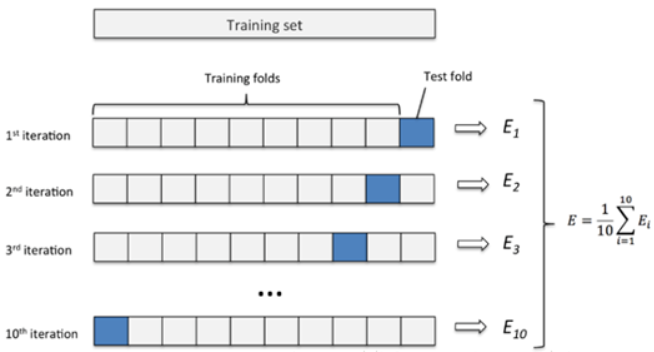

在这里K=4进行4折交叉验证，每一次验证迭代100次  
all_score记录每一轮迭代之后，网络在验证集上的准确率

In [52]:
import numpy as np

k = 4
n = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * n :(i + 1) * n]
    val_targets = train_targets[i * n : (i + 1) * n]
    
    partial_train_data = np.concatenate([train_data[ : i * n], train_data[(i + 1) * n:]], axis = 0)
    partial_train_targets = np.concatenate([train_targets[ : i * n], train_targets[(i + 1) * n :]], axis = 0)
    
    network = build_model()
    network.fit(train_data, train_targets, epochs = num_epochs, 
                batch_size = 1, validation_data = (val_data, val_targets))
    val_mse, val_mae = network.evaluate(val_data, val_targets)
    all_scores.append(val_mae)

processing fold # 0
Epoch 1/100
404/404 [==============================] - 1s 1ms/step - loss: 137.1881 - mae: 8.3190 - val_loss: 24.7548 - val_mae: 3.2481
Epoch 2/100
404/404 [==============================] - 1s 1ms/step - loss: 23.8045 - mae: 3.3073 - val_loss: 19.0110 - val_mae: 3.0276
Epoch 3/100
404/404 [==============================] - 0s 1ms/step - loss: 18.0578 - mae: 2.8867 - val_loss: 12.5305 - val_mae: 2.3678
Epoch 4/100
404/404 [==============================] - 0s 1ms/step - loss: 15.6055 - mae: 2.7179 - val_loss: 11.6369 - val_mae: 2.0370
Epoch 5/100
404/404 [==============================] - 0s 1ms/step - loss: 14.2419 - mae: 2.5221 - val_loss: 10.9654 - val_mae: 2.0119
Epoch 6/100
404/404 [==============================] - 0s 1ms/step - loss: 13.3404 - mae: 2.4764 - val_loss: 9.0192 - val_mae: 2.1366
Epoch 7/100
404/404 [==============================] - 0s 1ms/step - loss: 12.8838 - mae: 2.3936 - val_loss: 9.3871 - val_mae: 2.0814
Epoch 8/100
404/404 [===============

Epoch 62/100
404/404 [==============================] - 0s 1ms/step - loss: 5.2818 - mae: 1.5308 - val_loss: 2.4809 - val_mae: 1.1581
Epoch 63/100
404/404 [==============================] - 0s 1ms/step - loss: 5.6219 - mae: 1.5163 - val_loss: 2.4187 - val_mae: 1.1509
Epoch 64/100
404/404 [==============================] - 0s 1ms/step - loss: 5.2636 - mae: 1.4861 - val_loss: 2.4210 - val_mae: 1.1719
Epoch 65/100
404/404 [==============================] - 0s 1ms/step - loss: 5.4625 - mae: 1.4666 - val_loss: 2.9550 - val_mae: 1.3749
Epoch 66/100
404/404 [==============================] - 0s 1ms/step - loss: 5.0325 - mae: 1.4879 - val_loss: 2.9444 - val_mae: 1.2612
Epoch 67/100
404/404 [==============================] - 0s 1ms/step - loss: 4.9222 - mae: 1.4917 - val_loss: 2.0029 - val_mae: 1.0551
Epoch 68/100
404/404 [==============================] - 0s 1ms/step - loss: 5.0541 - mae: 1.4680 - val_loss: 2.0752 - val_mae: 1.0981
Epoch 69/100
404/404 [==============================] - 0s 1ms

404/404 [==============================] - 0s 1ms/step - loss: 4.9077 - mae: 1.4555 - val_loss: 3.7700 - val_mae: 1.4687
Epoch 84/100
404/404 [==============================] - 0s 1ms/step - loss: 4.4591 - mae: 1.4313 - val_loss: 2.7967 - val_mae: 1.2070
Epoch 85/100
404/404 [==============================] - 0s 1ms/step - loss: 4.3022 - mae: 1.3608 - val_loss: 2.8183 - val_mae: 1.1314
Epoch 86/100
404/404 [==============================] - 0s 1ms/step - loss: 4.4695 - mae: 1.3827 - val_loss: 3.1179 - val_mae: 1.1844
Epoch 87/100
404/404 [==============================] - 0s 1ms/step - loss: 4.3990 - mae: 1.3424 - val_loss: 5.3111 - val_mae: 1.8071
Epoch 88/100
404/404 [==============================] - 0s 1ms/step - loss: 4.2089 - mae: 1.4183 - val_loss: 2.7396 - val_mae: 1.1691
Epoch 89/100
404/404 [==============================] - 0s 1ms/step - loss: 4.4033 - mae: 1.3884 - val_loss: 2.4263 - val_mae: 1.1094
Epoch 90/100
404/404 [==============================] - 0s 1ms/step - loss:

404/404 [==============================] - 0s 1ms/step - loss: 17.0163 - mae: 2.8028 - val_loss: 22.5901 - val_mae: 3.2048
Epoch 4/100
404/404 [==============================] - 0s 1ms/step - loss: 15.6349 - mae: 2.6856 - val_loss: 18.9779 - val_mae: 2.8163
Epoch 5/100
404/404 [==============================] - 0s 1ms/step - loss: 13.5766 - mae: 2.5186 - val_loss: 15.0035 - val_mae: 2.5259
Epoch 6/100
404/404 [==============================] - 0s 1ms/step - loss: 12.6575 - mae: 2.5061 - val_loss: 19.3422 - val_mae: 2.8753
Epoch 7/100
404/404 [==============================] - 0s 1ms/step - loss: 12.9824 - mae: 2.4017 - val_loss: 12.6753 - val_mae: 2.2956
Epoch 8/100
404/404 [==============================] - 0s 1ms/step - loss: 11.7934 - mae: 2.3414 - val_loss: 12.1697 - val_mae: 2.4214
Epoch 9/100
404/404 [==============================] - 0s 1ms/step - loss: 11.0352 - mae: 2.2577 - val_loss: 13.2131 - val_mae: 2.3152
Epoch 10/100
404/404 [==============================] - 0s 1ms/step

查看结果

In [53]:
print(all_scores)
print(np.mean(all_scores))

[1.4447109699249268, 1.0166105031967163, 1.4384195804595947, 1.0438218116760254]
1.2358907163143158


让训练时间变得更加长一点，每一次迭代500次，  
为了记录模型在每一轮的表现，我们需要修改训练循环，以保存每轮验证分数记录

## 5、保存每折的验证结果
all_mae_histories记录每一次迭代之后在模型上得到的mae的平均值  
all_mae_histories[0]是4次交叉验证之后第一次迭代的平均值  

In [54]:
n = len(train_data) // k
num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * n : (i + 1) * n]
    val_targets = train_targets[i * n : (i + 1) * n]
    
    partial_train_data = np.concatenate([train_data[ : i * n], train_data[(i + 1) * n : ]], axis = 0)
    partial_train_targets = np.concatenate([train_targets[ : i * n], train_targets[(i + 1) * n : ]], axis = 0)
    
    network = build_model()
    history = network.fit(partial_train_data, partial_train_targets, epochs = num_epochs, 
                          batch_size = 1, validation_data = (val_data, val_targets))
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
Epoch 1/500
303/303 [==============================] - 1s 2ms/step - loss: 187.1101 - mae: 10.3698 - val_loss: 38.5198 - val_mae: 4.1543
Epoch 2/500
303/303 [==============================] - 0s 1ms/step - loss: 27.7811 - mae: 3.6127 - val_loss: 21.9037 - val_mae: 2.7450
Epoch 3/500
303/303 [==============================] - 0s 1ms/step - loss: 20.3499 - mae: 3.0045 - val_loss: 19.2519 - val_mae: 2.7993
Epoch 4/500
303/303 [==============================] - 0s 1ms/step - loss: 17.1740 - mae: 2.8318 - val_loss: 19.0137 - val_mae: 2.7063
Epoch 5/500
303/303 [==============================] - 0s 1ms/step - loss: 16.1596 - mae: 2.6694 - val_loss: 16.1783 - val_mae: 2.8450
Epoch 6/500
303/303 [==============================] - 0s 1ms/step - loss: 15.2384 - mae: 2.6085 - val_loss: 13.6628 - val_mae: 2.2932
Epoch 7/500
303/303 [==============================] - 0s 1ms/step - loss: 14.4109 - mae: 2.4984 - val_loss: 14.3813 - val_mae: 2.3639
Epoch 8/500
303/303 [============

Epoch 62/500
303/303 [==============================] - 0s 1ms/step - loss: 5.6960 - mae: 1.5930 - val_loss: 8.0772 - val_mae: 2.1026
Epoch 63/500
303/303 [==============================] - 0s 1ms/step - loss: 5.7509 - mae: 1.5024 - val_loss: 7.2801 - val_mae: 1.8514
Epoch 64/500
303/303 [==============================] - 0s 1ms/step - loss: 6.0062 - mae: 1.6635 - val_loss: 7.5087 - val_mae: 1.9469
Epoch 65/500
303/303 [==============================] - 0s 1ms/step - loss: 6.0005 - mae: 1.5659 - val_loss: 7.3685 - val_mae: 1.9672
Epoch 66/500
303/303 [==============================] - 0s 1ms/step - loss: 5.8489 - mae: 1.5568 - val_loss: 6.5468 - val_mae: 1.8219
Epoch 67/500
303/303 [==============================] - 0s 1ms/step - loss: 5.7141 - mae: 1.5978 - val_loss: 6.6615 - val_mae: 1.8514
Epoch 68/500
303/303 [==============================] - 0s 1ms/step - loss: 5.9252 - mae: 1.5814 - val_loss: 7.3448 - val_mae: 1.9869
Epoch 69/500
303/303 [==============================] - 0s 1ms

Epoch 123/500
303/303 [==============================] - 0s 1ms/step - loss: 3.6345 - mae: 1.2876 - val_loss: 5.8741 - val_mae: 1.7188
Epoch 124/500
303/303 [==============================] - 0s 1ms/step - loss: 3.9297 - mae: 1.2950 - val_loss: 6.6123 - val_mae: 1.9080
Epoch 125/500
303/303 [==============================] - 0s 1ms/step - loss: 3.2925 - mae: 1.2493 - val_loss: 7.6501 - val_mae: 1.9540
Epoch 126/500
303/303 [==============================] - 0s 1ms/step - loss: 3.6068 - mae: 1.2981 - val_loss: 6.8224 - val_mae: 1.8684
Epoch 127/500
303/303 [==============================] - 0s 1ms/step - loss: 3.6715 - mae: 1.2724 - val_loss: 8.2078 - val_mae: 2.1462
Epoch 128/500
303/303 [==============================] - 0s 1ms/step - loss: 3.5317 - mae: 1.2852 - val_loss: 8.2354 - val_mae: 2.0808
Epoch 129/500
303/303 [==============================] - 0s 1ms/step - loss: 3.2472 - mae: 1.2492 - val_loss: 7.7170 - val_mae: 1.9953
Epoch 130/500
303/303 [==============================] 

303/303 [==============================] - 0s 2ms/step - loss: 1.8064 - mae: 0.9744 - val_loss: 8.8942 - val_mae: 2.1884
Epoch 244/500
303/303 [==============================] - 0s 1ms/step - loss: 1.5610 - mae: 0.9483 - val_loss: 8.2923 - val_mae: 2.1349
Epoch 245/500
303/303 [==============================] - 0s 1ms/step - loss: 1.7228 - mae: 0.9361 - val_loss: 11.8640 - val_mae: 2.5913
Epoch 246/500
303/303 [==============================] - 0s 1ms/step - loss: 1.8679 - mae: 0.9927 - val_loss: 9.7993 - val_mae: 2.2256
Epoch 247/500
303/303 [==============================] - 0s 1ms/step - loss: 1.8842 - mae: 1.0206 - val_loss: 10.1731 - val_mae: 2.2597
Epoch 248/500
303/303 [==============================] - 0s 1ms/step - loss: 1.5989 - mae: 0.8721 - val_loss: 8.9382 - val_mae: 2.1576
Epoch 249/500
303/303 [==============================] - 0s 1ms/step - loss: 1.8930 - mae: 1.0464 - val_loss: 9.4054 - val_mae: 2.2146
Epoch 250/500
303/303 [==============================] - 0s 1ms/ste

303/303 [==============================] - 0s 1ms/step - loss: 1.3616 - mae: 0.8562 - val_loss: 11.0875 - val_mae: 2.3955
Epoch 364/500
303/303 [==============================] - 0s 1ms/step - loss: 1.2181 - mae: 0.8038 - val_loss: 9.8107 - val_mae: 2.3033
Epoch 365/500
303/303 [==============================] - 0s 1ms/step - loss: 1.3269 - mae: 0.8177 - val_loss: 12.2505 - val_mae: 2.5058
Epoch 366/500
303/303 [==============================] - 0s 1ms/step - loss: 1.1634 - mae: 0.7624 - val_loss: 9.7196 - val_mae: 2.1742
Epoch 367/500
303/303 [==============================] - 0s 1ms/step - loss: 1.2523 - mae: 0.7821 - val_loss: 10.4310 - val_mae: 2.3248
Epoch 368/500
303/303 [==============================] - 0s 1ms/step - loss: 1.2076 - mae: 0.7752 - val_loss: 11.1190 - val_mae: 2.3393
Epoch 369/500
303/303 [==============================] - 0s 1ms/step - loss: 1.2778 - mae: 0.7978 - val_loss: 10.3657 - val_mae: 2.2593
Epoch 370/500
303/303 [==============================] - 0s 1ms/

303/303 [==============================] - 0s 1ms/step - loss: 0.9812 - mae: 0.6926 - val_loss: 11.1010 - val_mae: 2.4259
Epoch 484/500
303/303 [==============================] - 0s 1ms/step - loss: 0.8151 - mae: 0.6628 - val_loss: 11.0725 - val_mae: 2.2381
Epoch 485/500
303/303 [==============================] - 0s 1ms/step - loss: 0.9365 - mae: 0.7120 - val_loss: 10.4087 - val_mae: 2.2940
Epoch 486/500
303/303 [==============================] - 0s 1ms/step - loss: 0.8825 - mae: 0.6913 - val_loss: 10.2847 - val_mae: 2.2312
Epoch 487/500
303/303 [==============================] - 0s 1ms/step - loss: 0.9644 - mae: 0.7244 - val_loss: 10.8686 - val_mae: 2.3133
Epoch 488/500
303/303 [==============================] - 0s 1ms/step - loss: 0.9056 - mae: 0.6901 - val_loss: 11.4822 - val_mae: 2.3390
Epoch 489/500
303/303 [==============================] - 0s 1ms/step - loss: 0.7845 - mae: 0.6410 - val_loss: 10.3848 - val_mae: 2.2029
Epoch 490/500
303/303 [==============================] - 0s 1m

Epoch 104/500
303/303 [==============================] - 0s 1ms/step - loss: 3.8088 - mae: 1.2898 - val_loss: 16.2024 - val_mae: 2.7196
Epoch 105/500
303/303 [==============================] - 0s 1ms/step - loss: 3.7012 - mae: 1.3127 - val_loss: 14.2526 - val_mae: 2.4128
Epoch 106/500
303/303 [==============================] - 0s 1ms/step - loss: 3.6930 - mae: 1.2931 - val_loss: 13.9634 - val_mae: 2.4374
Epoch 107/500
303/303 [==============================] - 0s 1ms/step - loss: 3.7429 - mae: 1.2537 - val_loss: 17.9123 - val_mae: 2.4708
Epoch 108/500
303/303 [==============================] - 0s 1ms/step - loss: 3.6477 - mae: 1.2816 - val_loss: 16.0724 - val_mae: 2.5689
Epoch 109/500
303/303 [==============================] - 0s 1ms/step - loss: 3.8226 - mae: 1.3237 - val_loss: 14.3640 - val_mae: 2.3947
Epoch 110/500
303/303 [==============================] - 0s 1ms/step - loss: 3.6803 - mae: 1.2472 - val_loss: 19.1581 - val_mae: 2.7330
Epoch 111/500
303/303 [=========================

303/303 [==============================] - 0s 1ms/step - loss: 1.7758 - mae: 0.9657 - val_loss: 29.5975 - val_mae: 2.9263
Epoch 225/500
303/303 [==============================] - 0s 1ms/step - loss: 1.8510 - mae: 0.9460 - val_loss: 28.5866 - val_mae: 2.9392
Epoch 226/500
303/303 [==============================] - 0s 1ms/step - loss: 1.4730 - mae: 0.8591 - val_loss: 33.1994 - val_mae: 3.2291
Epoch 227/500
303/303 [==============================] - 0s 1ms/step - loss: 1.7318 - mae: 0.9538 - val_loss: 23.4290 - val_mae: 2.8656
Epoch 228/500
303/303 [==============================] - 0s 1ms/step - loss: 1.6762 - mae: 0.8854 - val_loss: 26.0799 - val_mae: 2.8436
Epoch 229/500
303/303 [==============================] - 0s 1ms/step - loss: 1.7443 - mae: 0.8892 - val_loss: 31.0588 - val_mae: 2.9433
Epoch 230/500
303/303 [==============================] - 0s 1ms/step - loss: 1.6569 - mae: 0.9153 - val_loss: 34.2152 - val_mae: 3.2127
Epoch 231/500
303/303 [==============================] - 0s 1m

303/303 [==============================] - 0s 1ms/step - loss: 1.0782 - mae: 0.6914 - val_loss: 29.0305 - val_mae: 3.1089
Epoch 345/500
303/303 [==============================] - 0s 1ms/step - loss: 1.0255 - mae: 0.7380 - val_loss: 29.5761 - val_mae: 3.0372
Epoch 346/500
303/303 [==============================] - 0s 1ms/step - loss: 1.1531 - mae: 0.7851 - val_loss: 30.6246 - val_mae: 3.1481
Epoch 347/500
303/303 [==============================] - 0s 1ms/step - loss: 1.0537 - mae: 0.7553 - val_loss: 28.1546 - val_mae: 2.9700
Epoch 348/500
303/303 [==============================] - 0s 1ms/step - loss: 1.0074 - mae: 0.7332 - val_loss: 33.2712 - val_mae: 3.2112
Epoch 349/500
303/303 [==============================] - 0s 1ms/step - loss: 1.0792 - mae: 0.7582 - val_loss: 31.1769 - val_mae: 3.2070
Epoch 350/500
303/303 [==============================] - 0s 1ms/step - loss: 1.1474 - mae: 0.7985 - val_loss: 23.3955 - val_mae: 2.7931
Epoch 351/500
303/303 [==============================] - 0s 1m

303/303 [==============================] - 0s 1ms/step - loss: 0.7616 - mae: 0.6515 - val_loss: 33.2272 - val_mae: 3.1954
Epoch 465/500
303/303 [==============================] - 0s 1ms/step - loss: 0.9447 - mae: 0.6562 - val_loss: 31.2358 - val_mae: 3.1949
Epoch 466/500
303/303 [==============================] - 0s 1ms/step - loss: 0.8666 - mae: 0.6892 - val_loss: 32.8701 - val_mae: 3.4714
Epoch 467/500
303/303 [==============================] - 0s 1ms/step - loss: 0.8343 - mae: 0.6534 - val_loss: 31.0385 - val_mae: 3.2036
Epoch 468/500
303/303 [==============================] - 0s 1ms/step - loss: 0.8002 - mae: 0.6435 - val_loss: 38.0985 - val_mae: 3.3806
Epoch 469/500
303/303 [==============================] - 0s 1ms/step - loss: 0.7821 - mae: 0.6494 - val_loss: 32.2747 - val_mae: 3.1691
Epoch 470/500
303/303 [==============================] - 0s 1ms/step - loss: 0.9126 - mae: 0.6474 - val_loss: 26.2141 - val_mae: 3.0633
Epoch 471/500
303/303 [==============================] - 0s 1m

Epoch 85/500
303/303 [==============================] - 0s 1ms/step - loss: 3.1588 - mae: 1.2681 - val_loss: 13.8750 - val_mae: 2.4738
Epoch 86/500
303/303 [==============================] - 0s 1ms/step - loss: 3.1700 - mae: 1.2591 - val_loss: 12.9577 - val_mae: 2.5907
Epoch 87/500
303/303 [==============================] - 0s 1ms/step - loss: 3.0609 - mae: 1.2086 - val_loss: 12.4181 - val_mae: 2.4777
Epoch 88/500
303/303 [==============================] - 0s 1ms/step - loss: 3.0081 - mae: 1.1983 - val_loss: 12.7565 - val_mae: 2.5733
Epoch 89/500
303/303 [==============================] - 0s 1ms/step - loss: 2.9803 - mae: 1.2030 - val_loss: 14.2925 - val_mae: 2.6976
Epoch 90/500
303/303 [==============================] - 0s 1ms/step - loss: 2.6404 - mae: 1.1919 - val_loss: 14.9689 - val_mae: 2.8267
Epoch 91/500
303/303 [==============================] - 0s 1ms/step - loss: 3.0767 - mae: 1.2352 - val_loss: 12.5738 - val_mae: 2.5392
Epoch 92/500
303/303 [==============================] -

303/303 [==============================] - 0s 1ms/step - loss: 1.1730 - mae: 0.7740 - val_loss: 12.6190 - val_mae: 2.6348
Epoch 206/500
303/303 [==============================] - 0s 1ms/step - loss: 1.2189 - mae: 0.8239 - val_loss: 14.7766 - val_mae: 2.7336
Epoch 207/500
303/303 [==============================] - 0s 1ms/step - loss: 1.2125 - mae: 0.8095 - val_loss: 15.3464 - val_mae: 2.7092
Epoch 208/500
303/303 [==============================] - 0s 1ms/step - loss: 1.3301 - mae: 0.8460 - val_loss: 13.6102 - val_mae: 2.6616
Epoch 209/500
303/303 [==============================] - 0s 1ms/step - loss: 1.2653 - mae: 0.7842 - val_loss: 13.3557 - val_mae: 2.6065
Epoch 210/500
303/303 [==============================] - 0s 1ms/step - loss: 1.1856 - mae: 0.8293 - val_loss: 13.4003 - val_mae: 2.5392
Epoch 211/500
303/303 [==============================] - 0s 1ms/step - loss: 1.0381 - mae: 0.7576 - val_loss: 13.4483 - val_mae: 2.5863
Epoch 212/500
303/303 [==============================] - 0s 1m

303/303 [==============================] - 0s 1ms/step - loss: 0.8216 - mae: 0.6529 - val_loss: 14.6529 - val_mae: 2.6164
Epoch 326/500
303/303 [==============================] - 0s 1ms/step - loss: 0.8025 - mae: 0.6756 - val_loss: 15.5267 - val_mae: 2.6652
Epoch 327/500
303/303 [==============================] - 0s 1ms/step - loss: 0.7859 - mae: 0.6521 - val_loss: 14.2091 - val_mae: 2.5120
Epoch 328/500
303/303 [==============================] - 0s 1ms/step - loss: 0.7976 - mae: 0.6691 - val_loss: 14.1585 - val_mae: 2.6152
Epoch 329/500
303/303 [==============================] - 0s 1ms/step - loss: 0.8384 - mae: 0.6551 - val_loss: 15.2636 - val_mae: 2.7003
Epoch 330/500
303/303 [==============================] - 0s 1ms/step - loss: 0.8354 - mae: 0.6576 - val_loss: 14.1603 - val_mae: 2.5497
Epoch 331/500
303/303 [==============================] - 0s 1ms/step - loss: 0.9062 - mae: 0.6885 - val_loss: 15.2274 - val_mae: 2.6242
Epoch 332/500
303/303 [==============================] - 0s 1m

303/303 [==============================] - 0s 1ms/step - loss: 0.7467 - mae: 0.6067 - val_loss: 14.3355 - val_mae: 2.6224
Epoch 446/500
303/303 [==============================] - 0s 1ms/step - loss: 0.5741 - mae: 0.5525 - val_loss: 15.0284 - val_mae: 2.5913
Epoch 447/500
303/303 [==============================] - 0s 1ms/step - loss: 0.6582 - mae: 0.5771 - val_loss: 15.0941 - val_mae: 2.6695
Epoch 448/500
303/303 [==============================] - 0s 1ms/step - loss: 0.6289 - mae: 0.5795 - val_loss: 15.1797 - val_mae: 2.5955
Epoch 449/500
303/303 [==============================] - 0s 1ms/step - loss: 0.6511 - mae: 0.5931 - val_loss: 15.5820 - val_mae: 2.6353
Epoch 450/500
303/303 [==============================] - 0s 1ms/step - loss: 0.6504 - mae: 0.6002 - val_loss: 13.9612 - val_mae: 2.6129
Epoch 451/500
303/303 [==============================] - 0s 1ms/step - loss: 0.6815 - mae: 0.5980 - val_loss: 15.7439 - val_mae: 2.6660
Epoch 452/500
303/303 [==============================] - 0s 1m

Epoch 66/500
303/303 [==============================] - 0s 1ms/step - loss: 5.7913 - mae: 1.5021 - val_loss: 15.1274 - val_mae: 2.9682
Epoch 67/500
303/303 [==============================] - 0s 1ms/step - loss: 5.9187 - mae: 1.5272 - val_loss: 12.6950 - val_mae: 2.6107
Epoch 68/500
303/303 [==============================] - 0s 1ms/step - loss: 5.8895 - mae: 1.5921 - val_loss: 13.3003 - val_mae: 2.5781
Epoch 69/500
303/303 [==============================] - 0s 1ms/step - loss: 5.5032 - mae: 1.4920 - val_loss: 12.9426 - val_mae: 2.5628
Epoch 70/500
303/303 [==============================] - 0s 1ms/step - loss: 5.2190 - mae: 1.4495 - val_loss: 13.0414 - val_mae: 2.5438
Epoch 71/500
303/303 [==============================] - 0s 1ms/step - loss: 5.4909 - mae: 1.5081 - val_loss: 12.8793 - val_mae: 2.5176
Epoch 72/500
303/303 [==============================] - 0s 1ms/step - loss: 5.1382 - mae: 1.4888 - val_loss: 12.0816 - val_mae: 2.4816
Epoch 73/500
303/303 [==============================] -

303/303 [==============================] - 0s 1ms/step - loss: 2.7166 - mae: 1.0339 - val_loss: 13.9619 - val_mae: 2.7552
Epoch 187/500
303/303 [==============================] - 0s 1ms/step - loss: 2.7964 - mae: 1.0546 - val_loss: 13.4998 - val_mae: 2.6728
Epoch 188/500
303/303 [==============================] - 0s 1ms/step - loss: 2.6903 - mae: 1.0596 - val_loss: 14.6464 - val_mae: 2.7785
Epoch 189/500
303/303 [==============================] - 0s 1ms/step - loss: 2.8698 - mae: 1.0809 - val_loss: 15.4805 - val_mae: 3.0842
Epoch 190/500
303/303 [==============================] - 0s 1ms/step - loss: 2.6370 - mae: 1.0599 - val_loss: 13.1022 - val_mae: 2.6755
Epoch 191/500
303/303 [==============================] - 0s 1ms/step - loss: 2.5247 - mae: 0.9911 - val_loss: 13.0611 - val_mae: 2.7598
Epoch 192/500
303/303 [==============================] - 0s 1ms/step - loss: 2.5902 - mae: 1.0823 - val_loss: 14.6116 - val_mae: 2.7844
Epoch 193/500
303/303 [==============================] - 0s 1m

303/303 [==============================] - 0s 1ms/step - loss: 1.5128 - mae: 0.8450 - val_loss: 15.2303 - val_mae: 2.7970
Epoch 307/500
303/303 [==============================] - 0s 1ms/step - loss: 1.4162 - mae: 0.8693 - val_loss: 18.6826 - val_mae: 2.9790
Epoch 308/500
303/303 [==============================] - 0s 1ms/step - loss: 1.5931 - mae: 0.8877 - val_loss: 15.0619 - val_mae: 2.7836
Epoch 309/500
303/303 [==============================] - 0s 1ms/step - loss: 1.5575 - mae: 0.8727 - val_loss: 15.3505 - val_mae: 2.7666
Epoch 310/500
303/303 [==============================] - 0s 1ms/step - loss: 1.4489 - mae: 0.8588 - val_loss: 17.6746 - val_mae: 3.0152
Epoch 311/500
303/303 [==============================] - 0s 1ms/step - loss: 1.3242 - mae: 0.8370 - val_loss: 17.9401 - val_mae: 3.0413
Epoch 312/500
303/303 [==============================] - 0s 1ms/step - loss: 1.5047 - mae: 0.9044 - val_loss: 15.8573 - val_mae: 2.8665
Epoch 313/500
303/303 [==============================] - 0s 1m

303/303 [==============================] - 0s 1ms/step - loss: 1.1104 - mae: 0.7733 - val_loss: 15.6131 - val_mae: 2.8553
Epoch 427/500
303/303 [==============================] - 0s 1ms/step - loss: 0.9477 - mae: 0.7148 - val_loss: 16.6123 - val_mae: 3.0200
Epoch 428/500
303/303 [==============================] - 0s 1ms/step - loss: 1.1976 - mae: 0.8068 - val_loss: 17.0720 - val_mae: 3.1078
Epoch 429/500
303/303 [==============================] - 0s 1ms/step - loss: 1.0380 - mae: 0.7529 - val_loss: 18.4327 - val_mae: 3.0873
Epoch 430/500
303/303 [==============================] - 0s 1ms/step - loss: 1.0511 - mae: 0.7574 - val_loss: 15.7181 - val_mae: 2.8705
Epoch 431/500
303/303 [==============================] - 0s 1ms/step - loss: 1.0168 - mae: 0.7532 - val_loss: 16.6674 - val_mae: 2.9057
Epoch 432/500
303/303 [==============================] - 0s 1ms/step - loss: 1.1524 - mae: 0.7719 - val_loss: 16.3015 - val_mae: 3.0356
Epoch 433/500
303/303 [==============================] - 0s 1m

计算每个轮次中所有折MAE的平均值  
all_mae_histories是4 * 500的一个列表   
将all_mae_histories转换为avg_mae_history(1 * 500的列表)

In [55]:
avg_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

上面表达式等价于
avg_mae_history = []
for i in range(num_epochs):
    sum = 0
    for x in all_mae_histories:
        sum += x[i]
   avg_mae_history.append(sum / len(all_mae_histories))

## 6、绘制验证分数

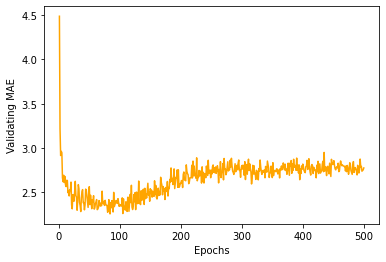

In [56]:
import matplotlib.pyplot as plt

epochs = range(1, len(avg_mae_history) + 1)
plt.plot(epochs, avg_mae_history, 'orange')
plt.xlabel('Epochs')
plt.ylabel('Validating MAE')
plt.show()

## 7、使用指数平移的方式重新绘制验证分数

In [57]:
def smooth_curve(points, factor = 0.9):
    smoothed_point = []
    for point in points:
        if smoothed_point:
            previous = smoothed_point[-1]
            smoothed_point.append(previous * factor + (1 - factor) * point)
        else:
            smoothed_point.append(point)
    return smoothed_point

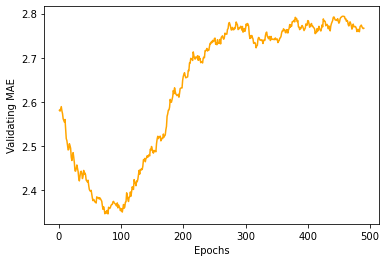

In [58]:
smoothed_mae_history = smooth_curve(avg_mae_history[10 : ])

epochs = range(1, len(smoothed_mae_history) + 1)
plt.plot(epochs, smoothed_mae_history, 'orange')
plt.xlabel('Epochs')
plt.ylabel('Validating MAE')
plt.show()

## 8、训练最终模型

In [59]:
network = build_model()

network.fit(train_data, train_targets, epochs = 80, batch_size = 16, 
            validation_data = (test_data, test_targets))

test_mse, test_mae = network.evaluate(test_data, test_targets)

Epoch 1/130
26/26 [==============================] - 1s 6ms/step - loss: 480.2212 - mae: 19.7226 - val_loss: 417.2126 - val_mae: 18.1370
Epoch 2/130
26/26 [==============================] - 0s 3ms/step - loss: 305.6689 - mae: 14.8821 - val_loss: 231.1281 - val_mae: 13.0658
Epoch 3/130
26/26 [==============================] - 0s 3ms/step - loss: 140.5025 - mae: 9.3399 - val_loss: 98.9494 - val_mae: 8.2200
Epoch 4/130
26/26 [==============================] - 0s 2ms/step - loss: 62.6246 - mae: 5.9128 - val_loss: 54.7691 - val_mae: 5.5957
Epoch 5/130
26/26 [==============================] - 0s 3ms/step - loss: 39.7584 - mae: 4.6121 - val_loss: 37.5410 - val_mae: 4.6558
Epoch 6/130
26/26 [==============================] - 0s 3ms/step - loss: 29.1870 - mae: 3.8630 - val_loss: 27.9153 - val_mae: 4.1373
Epoch 7/130
26/26 [==============================] - 0s 3ms/step - loss: 23.7026 - mae: 3.4502 - val_loss: 23.5949 - val_mae: 3.9548
Epoch 8/130
26/26 [==============================] - 0s 3ms/

26/26 [==============================] - 0s 2ms/step - loss: 4.3295 - mae: 1.4378 - val_loss: 17.6998 - val_mae: 2.6554
Epoch 124/130
26/26 [==============================] - 0s 2ms/step - loss: 4.2191 - mae: 1.4156 - val_loss: 19.1176 - val_mae: 2.8691
Epoch 125/130
26/26 [==============================] - 0s 2ms/step - loss: 4.1111 - mae: 1.4206 - val_loss: 17.0461 - val_mae: 2.6053
Epoch 126/130
26/26 [==============================] - 0s 2ms/step - loss: 4.1669 - mae: 1.4467 - val_loss: 19.5859 - val_mae: 2.8551
Epoch 127/130
26/26 [==============================] - 0s 2ms/step - loss: 4.1207 - mae: 1.4291 - val_loss: 20.2872 - val_mae: 2.9973
Epoch 128/130
26/26 [==============================] - 0s 2ms/step - loss: 3.8972 - mae: 1.3865 - val_loss: 18.9323 - val_mae: 2.8151
Epoch 129/130
26/26 [==============================] - 0s 2ms/step - loss: 4.1253 - mae: 1.4376 - val_loss: 18.7865 - val_mae: 2.8645
Epoch 130/130
4/4 [==============================] - 0s 2ms/step - loss: 17.

In [60]:
print(f"test_mse: {test_mse}")
print(f"test_mae: {test_mae}")

test_mse: 17.646163940429688
test_mae: 2.667193651199341


## 9、小结
和分类问题不同，回归问题的损失函数是MSE，评估指标是MAE  
(1)对于输入数据的特征取值差异很大，应该对每个数据进行预处理   
(2)如果数据比较少，可以使用K折交叉验证来训练模型   
(3)训练数据比较少，最好使用隐藏层比较少的小型网络